In [182]:
import evolution as Evo
from utilities import VarCircuit, SU4_Circuits
from utilities_MPS import expectation
import numpy as np
import matplotlib.pyplot as plt
import functools as f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [192]:
# Time steps
TOTAL_TIME = 3
STEP_SIZE = 0.05
NUM_STEPS = int(TOTAL_TIME/STEP_SIZE)

# Pauli operators
sigmax = np.array([[0., 1], [1, 0.]])
sigmay = np.array([[0., -1j], [1j, 0.]])
sigmaz = np.array([[1, 0.], [0., -1]])
id = np.eye(2)

# Initialize states
ini_dir = np.array([[np.pi/2, np.pi/2, np.pi/2, 0,0,0, 0,0,0, 0,0,0]])
ini_mps = np.array([[0,0,0, 0,0,0, 0,0,0, 0,0,0],
                [np.pi/2, np.pi/2, np.pi/2, 0,0,0, 0,0,0, 0,0,0]])
# ini = np.array([[np.pi/2, np.pi/2, np.pi/2, 0, e, e, 0, e, 0, 0, e, e, 0, e, e], 
#                  [np.pi/2, np.pi/2, np.pi/2, 0, e, e, 0, e, 0, 0, e, e, 0, e, e]])

In [184]:
L = 2
b_dim = 2
bdry_vec = np.zeros([b_dim,b_dim])
bdry_vec[0][0] = 1
tensor_list = [np.conj(U).T.reshape(2,b_dim,2,b_dim) for U in SU4_Circuits(L, ini_mps, 2).u_list()]
expectation_X_var1 = np.round(np.real(expectation(tensor_list, [1,0], bdry_vec)^all), 2)
expectation_X_var2 = np.round(np.real(expectation(tensor_list, [0,1], bdry_vec)^all), 2)
expectation_Y_var1 = np.round(np.real(expectation(tensor_list, [2,0], bdry_vec)^all), 2)
expectation_Y_var2 = np.round(np.real(expectation(tensor_list, [0,2], bdry_vec)^all), 2)
expectation_Z_var1 = np.round(np.real(expectation(tensor_list, [3,0], bdry_vec)^all), 2)
expectation_Z_var2 = np.round(np.real(expectation(tensor_list, [0,3], bdry_vec)^all), 2)

print("X: ", expectation_X_var1, expectation_X_var2)
print("Y: ", expectation_Y_var1, expectation_Y_var2)
print("Z: ", expectation_Z_var1, expectation_Z_var2)

X:  0.0 1.0
Y:  0.0 0.0
Z:  1.0 0.0


## MPS Evolution

In [193]:
L = 2

# Variational evolution (with MPS)
var_params_mps, var_circuits_all_mps, E_final = Evo.evolution_adiabatic_mps(SU4_Circuits(L, ini_mps, L), L, L, NUM_STEPS, STEP_SIZE)
print(E_final)

(-0.5506319130441572+2.656295322589486e-17j)


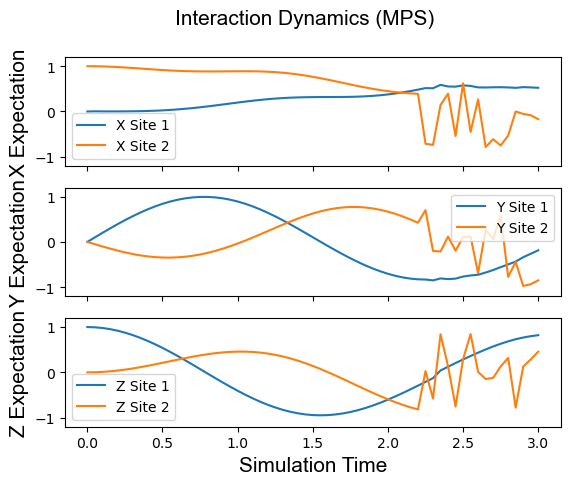

In [194]:
# Compute Z expectation
expectation_Z_1_mps = np.zeros(NUM_STEPS+1)
expectation_Z_2_mps = np.zeros(NUM_STEPS+1)
expectation_Y_1_mps = np.zeros(NUM_STEPS+1)
expectation_Y_2_mps = np.zeros(NUM_STEPS+1)
expectation_X_1_mps = np.zeros(NUM_STEPS+1)
expectation_X_2_mps = np.zeros(NUM_STEPS+1)
b_dim = 2
bdry_vec = np.zeros([b_dim,b_dim])
bdry_vec[0][0] = 1
for t in range(NUM_STEPS+1):
    tensor_list = [np.conj(U).T.reshape(2,b_dim,2,b_dim) for U in var_circuits_all_mps[t].u_list()]
    # expectation_Z_1[t] = np.real(expectation(tensor_list, [3,0], bdry_vec)^all)
    expectation_Z_1_mps[t] = np.real(expectation(tensor_list, [3,0], bdry_vec)^all)
    expectation_Z_2_mps[t] = np.real(expectation(tensor_list, [0,3], bdry_vec)^all)
    expectation_Y_1_mps[t] = np.real(expectation(tensor_list, [2,0], bdry_vec)^all)
    expectation_Y_2_mps[t] = np.real(expectation(tensor_list, [0,2], bdry_vec)^all)
    expectation_X_1_mps[t] = np.real(expectation(tensor_list, [1,0], bdry_vec)^all)
    expectation_X_2_mps[t] = np.real(expectation(tensor_list, [0,1], bdry_vec)^all)


# Plot 
t = np.linspace(0, STEP_SIZE * NUM_STEPS, NUM_STEPS+1)
axis_font = {'fontname':'Arial', 'size':'15'}

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True)
fig.suptitle('Interaction Dynamics (MPS)', **axis_font)

ax1.plot(t, expectation_X_1_mps, label = "X Site 1")
ax1.plot(t, expectation_X_2_mps, label = "X Site 2")
ax2.plot(t, expectation_Y_1_mps, label = "Y Site 1")
ax2.plot(t, expectation_Y_2_mps, label = "Y Site 2")
ax3.plot(t, expectation_Z_1_mps, label = "Z Site 1")
ax3.plot(t, expectation_Z_2_mps, label = "Z Site 2")
ax1.set_ylim([-1.2,1.2])
ax3.set_xlabel("Simulation Time", **axis_font)
ax1.set_ylabel("X Expectation", **axis_font)
ax2.set_ylabel("Y Expectation", **axis_font)
ax3.set_ylabel("Z Expectation", **axis_font)
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


## Unrolled Circuit

In [197]:
L = 2
# H0 = np.kron(id, np.kron(sigmaz, id)) + np.kron(id, np.kron(id, sigmaz))
H0 = - 0.5*np.kron(id, np.kron(sigmaz, sigmaz)) - np.kron(id, np.kron(sigmax, id)) - np.kron(id, np.kron(id, sigmax))
var_params_ur, var_circuits_all_ur = Evo.evolution_variational(H0, H0, SU4_Circuits(L, ini_mps, L+1, type = "direct"), L, L+1, NUM_STEPS, STEP_SIZE)

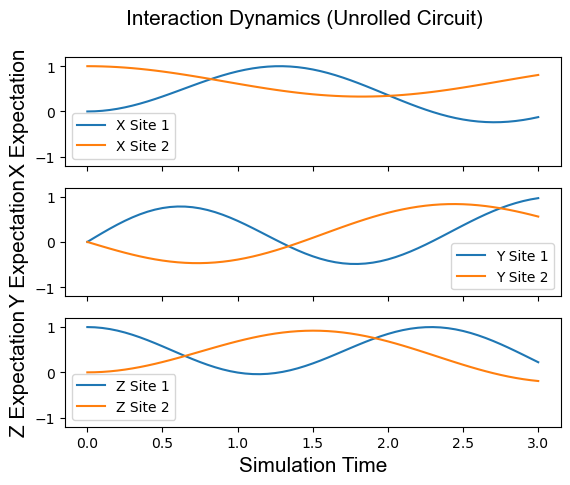

In [198]:
L = 2
def get_expectation_ur(t, operator):
    bra = [np.conj(var_circuits_all_ur[t].u_list()[l]).T for l in range(L)]
    ket = [var_circuits_all_ur[t].u_list()[l] for l in range(L-1,-1,-1)]
    return f.reduce(lambda a, b: a @ b, np.concatenate((bra, [operator], ket)))[0][0]


X1 = VarCircuit(0, L+1, "X", 1, rotation=False).ket()
Y1 = VarCircuit(0, L+1, "Y", 1, rotation=False).ket()
Z1 = VarCircuit(0, L+1, "Z", 1, rotation=False).ket()
X2 = VarCircuit(0, L+1, "X", 2, rotation=False).ket()
Y2 = VarCircuit(0, L+1, "Y", 2, rotation=False).ket()
Z2 = VarCircuit(0, L+1, "Z", 2, rotation=False).ket()
ZZ = VarCircuit(0, L+1, "Z", 1, "Z", 2, rotation=False).ket()
YY = VarCircuit(0, L+1, "Y", 1, "Y", 2, rotation=False).ket()
XX = VarCircuit(0, L+1, "X", 1, "X", 2, rotation=False).ket()

expectation_Z_2_ur = [get_expectation_ur(t, Z2) for t in range(NUM_STEPS+1)]
expectation_Z_1_ur = [get_expectation_ur(t, Z1) for t in range(NUM_STEPS+1)]
expectation_X_1_ur = [get_expectation_ur(t, X1) for t in range(NUM_STEPS+1)]
expectation_X_2_ur = [get_expectation_ur(t, X2) for t in range(NUM_STEPS+1)]
expectation_Y_1_ur = [get_expectation_ur(t, Y1) for t in range(NUM_STEPS+1)]
expectation_Y_2_ur = [get_expectation_ur(t, Y2) for t in range(NUM_STEPS+1)]

ZZ = [var_params_ur[t][0][8] for t in range(NUM_STEPS+1)]



# Plot 
t = np.linspace(0, STEP_SIZE * NUM_STEPS, NUM_STEPS+1)
axis_font = {'fontname':'Arial', 'size':'15'}

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True)
fig.suptitle('Interaction Dynamics (Unrolled Circuit)', **axis_font)
# ax1.plot(t, expectation_Z_1, label = "Z Site 1")

ax1.plot(t, expectation_X_1_ur, label = "X Site 1")
ax1.plot(t, expectation_X_2_ur, label = "X Site 2")
ax2.plot(t, expectation_Y_1_ur, label = "Y Site 1")
ax2.plot(t, expectation_Y_2_ur, label = "Y Site 2")
ax3.plot(t, expectation_Z_1_ur, label = "Z Site 1")
ax3.plot(t, expectation_Z_2_ur, label = "Z Site 2")
ax1.set_ylim([-1.2,1.2])
ax3.set_xlabel("Simulation Time", **axis_font)
ax1.set_ylabel("X Expectation", **axis_font)
ax2.set_ylabel("Y Expectation", **axis_font)
ax3.set_ylabel("Z Expectation", **axis_font)
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

## Direct Exponentiation

In [199]:
L = 1

H0 = - 0.5*np.kron(sigmaz, sigmaz) - np.kron(sigmax, id) - np.kron(id, sigmax)
# H0 = np.kron(sigmaz, id) + np.kron(id, sigmaz)
# H0 = - np.kron(id, np.kron(sigmaz, sigmaz)) - np.kron(id, np.kron(sigmax, id)) - np.kron(id, np.kron(id, sigmax))
var_params_dir, var_circuits_all_dir = Evo.evolution_variational(H0, H0, SU4_Circuits(L, ini_dir, L+1, type = "direct"), L, L+1, NUM_STEPS, STEP_SIZE)

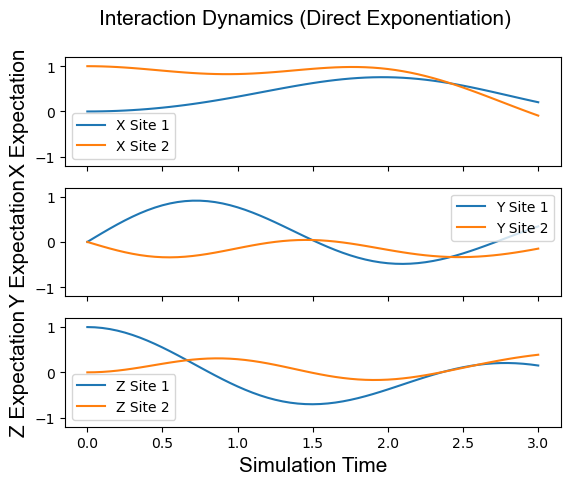

In [200]:
def get_expectation_dir(t, operator):
    bra = [np.conj(var_circuits_all_dir[t].u_list()[l]).T for l in range(L)]
    ket = [var_circuits_all_dir[t].u_list()[l] for l in range(L-1,-1,-1)]
    return f.reduce(lambda a, b: a @ b, np.concatenate((bra, [operator], ket)))[0][0]


X1 = VarCircuit(0, L+1, "X", 0, rotation=False).ket()
Y1 = VarCircuit(0, L+1, "Y", 0, rotation=False).ket()
Z1 = VarCircuit(0, L+1, "Z", 0, rotation=False).ket()
X2 = VarCircuit(0, L+1, "X", 1, rotation=False).ket()
Y2 = VarCircuit(0, L+1, "Y", 1, rotation=False).ket()
Z2 = VarCircuit(0, L+1, "Z", 1, rotation=False).ket()
ZZ = VarCircuit(0, L+1, "Z", 1, "Z", 0, rotation=False).ket()
YY = VarCircuit(0, L+1, "Y", 1, "Y", 0, rotation=False).ket()
XX = VarCircuit(0, L+1, "X", 1, "X", 0, rotation=False).ket()

expectation_Z_2 = [get_expectation_dir(t, Z2) for t in range(NUM_STEPS+1)]
expectation_Z_1 = [get_expectation_dir(t, Z1) for t in range(NUM_STEPS+1)]
expectation_X_1 = [get_expectation_dir(t, X1) for t in range(NUM_STEPS+1)]
expectation_X_2 = [get_expectation_dir(t, X2) for t in range(NUM_STEPS+1)]
expectation_Y_1 = [get_expectation_dir(t, Y1) for t in range(NUM_STEPS+1)]
expectation_Y_2 = [get_expectation_dir(t, Y2) for t in range(NUM_STEPS+1)]
expectation_XX = [get_expectation_dir(t, XX) for t in range(NUM_STEPS+1)]
expectation_YY = [get_expectation_dir(t, YY) for t in range(NUM_STEPS+1)]
expectation_ZZ = [get_expectation_dir(t, ZZ) for t in range(NUM_STEPS+1)]

ZZ = [var_params_dir[t][0][8] for t in range(NUM_STEPS+1)]



# Plot 
t = np.linspace(0, STEP_SIZE * NUM_STEPS, NUM_STEPS+1)
axis_font = {'fontname':'Arial', 'size':'15'}

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True)
fig.suptitle('Interaction Dynamics (Direct Exponentiation)', **axis_font)
# ax1.plot(t, expectation_Z_1, label = "Z Site 1")

ax1.plot(t, expectation_X_1, label = "X Site 1")
ax1.plot(t, expectation_X_2, label = "X Site 2")
ax2.plot(t, expectation_Y_1, label = "Y Site 1")
ax2.plot(t, expectation_Y_2, label = "Y Site 2")
ax3.plot(t, expectation_Z_1, label = "Z Site 1")
ax3.plot(t, expectation_Z_2, label = "Z Site 2")
ax1.set_ylim([-1.2,1.2])
ax3.set_xlabel("Simulation Time", **axis_font)
ax1.set_ylabel("X Expectation", **axis_font)
ax2.set_ylabel("Y Expectation", **axis_font)
ax3.set_ylabel("Z Expectation", **axis_font)
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

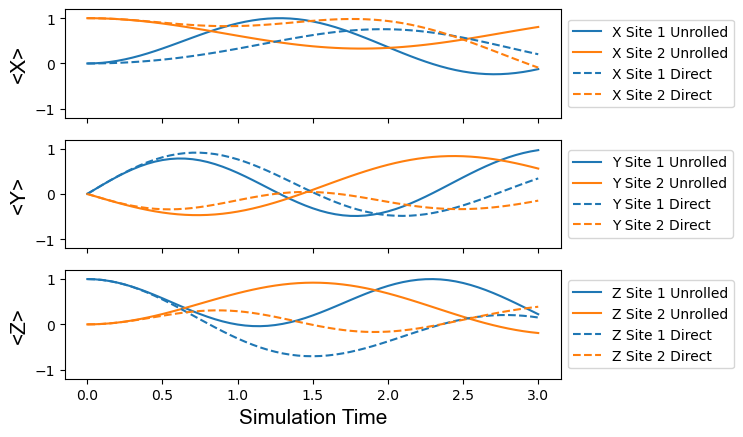

In [201]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True)

ax1.plot(t, expectation_X_1_ur, c='tab:blue', label = "X Site 1 Unrolled")
ax1.plot(t, expectation_X_2_ur, c='tab:orange', label = "X Site 2 Unrolled")
ax2.plot(t, expectation_Y_1_ur, c='tab:blue', label = "Y Site 1 Unrolled")
ax2.plot(t, expectation_Y_2_ur, c='tab:orange', label = "Y Site 2 Unrolled")
ax3.plot(t, expectation_Z_1_ur, c='tab:blue', label = "Z Site 1 Unrolled")
ax3.plot(t, expectation_Z_2_ur, c='tab:orange', label = "Z Site 2 Unrolled")

ax1.plot(t, expectation_X_1, linestyle='--', c='tab:blue', label = "X Site 1 Direct")
ax1.plot(t, expectation_X_2, linestyle='--', c='tab:orange', label = "X Site 2 Direct")
ax2.plot(t, expectation_Y_1, linestyle='--', c='tab:blue', label = "Y Site 1 Direct")
ax2.plot(t, expectation_Y_2, linestyle='--', c='tab:orange', label = "Y Site 2 Direct")
ax3.plot(t, expectation_Z_1, linestyle='--', c='tab:blue', label = "Z Site 1 Direct")
ax3.plot(t, expectation_Z_2, linestyle='--', c='tab:orange', label = "Z Site 2 Direct")

ax1.set_ylim([-1.2,1.2])
ax3.set_xlabel("Simulation Time", **axis_font)
ax1.set_ylabel("<X>", **axis_font)
ax2.set_ylabel("<Y>", **axis_font)
ax3.set_ylabel("<Z>", **axis_font)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

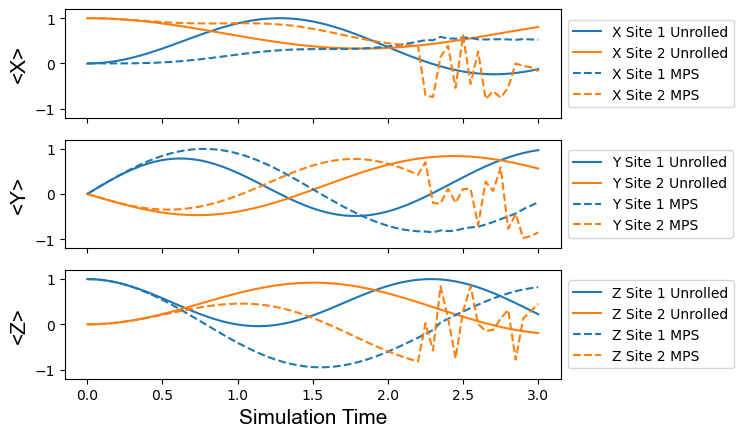

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True)

ax1.plot(t, expectation_X_1_ur, c='tab:blue', label = "X Site 1 Unrolled")
ax1.plot(t, expectation_X_2_ur, c='tab:orange', label = "X Site 2 Unrolled")
ax2.plot(t, expectation_Y_1_ur, c='tab:blue', label = "Y Site 1 Unrolled")
ax2.plot(t, expectation_Y_2_ur, c='tab:orange', label = "Y Site 2 Unrolled")
ax3.plot(t, expectation_Z_1_ur, c='tab:blue', label = "Z Site 1 Unrolled")
ax3.plot(t, expectation_Z_2_ur, c='tab:orange', label = "Z Site 2 Unrolled")

ax1.plot(t, expectation_X_1_mps, linestyle='--', c='tab:blue', label = "X Site 1 MPS")
ax1.plot(t, expectation_X_2_mps, linestyle='--', c='tab:orange', label = "X Site 2 MPS")
ax2.plot(t, expectation_Y_1_mps, linestyle='--', c='tab:blue', label = "Y Site 1 MPS")
ax2.plot(t, expectation_Y_2_mps, linestyle='--', c='tab:orange', label = "Y Site 2 MPS")
ax3.plot(t, expectation_Z_1_mps, linestyle='--', c='tab:blue', label = "Z Site 1 MPS")
ax3.plot(t, expectation_Z_2_mps, linestyle='--', c='tab:orange', label = "Z Site 2 MPS")

ax1.set_ylim([-1.2,1.2])
ax3.set_xlabel("Simulation Time", **axis_font)
ax1.set_ylabel("<X>", **axis_font)
ax2.set_ylabel("<Y>", **axis_font)
ax3.set_ylabel("<Z>", **axis_font)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()